In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, TextInput, DateRangeSlider, HelpButton, Tooltip, DataTable
from bokeh.models import NumberFormatter, TableColumn, RadioGroup
from bokeh.plotting import figure
from bokeh.models.dom import HTML
from bokeh.themes import Theme

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error




#CONSTANTS
MAX_WIDTH_SLIDERS=600
BACKGROUND_C= "#fefffa"



'''SYNTHETIC DATA GENERATION0.03
INCLUDING: {
seasonal_component: amplitude, frequency, shift
trend_component: slope, quadratic_curvature, CUBIC_CURVATURE
noise: standard normal distributed with mean=0, sd=1
AUTOCORELLATION : 
}
'''


# -----------------------------------------------TIME SERIES GENERATOR FUNDAMENTALS---------------------------------- #

def generate_seasonal_component(t, amplitude, frequency, shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + shift* np.pi)

def generate_trend_component(t, slope, curvature_quadratic, curvature_cubic):
    return slope * t + curvature_quadratic * t**2 + curvature_cubic * t**3

def generate_autoregressive_component(t, ar_coefficients):
    ar_data = np.zeros_like(t)
    for i in range(len(ar_coefficients)):
        if i == 0:
            continue
        ar_data[i] = np.sum(ar_data[:i] * ar_coefficients[:i]) + np.random.randn()    
    return ar_data

def generate_noise(noise_level):
    return np.round(noise_level * np.random.randn(len(t)),4)

def generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic, curvature_cubic,
                                   ar_coefficients=None):
    seasonal_component = generate_seasonal_component(t, amplitude, frequency, shift)
    trend_component = generate_trend_component(t, slope, curvature_quadratic, curvature_cubic)
    
    if ar_coefficients is not None:
        ar_data = generate_autoregressive_component(t, ar_coefficients)
    else:
        ar_data = np.zeros_like(t)

    synthetic_data_ = seasonal_component + trend_component + ar_data
    return np.round(synthetic_data_, 4)

# SET INITIAL PARAMETERS   
t = np.linspace(0, 30, 90)
amplitude = 2.0
shift = 0
frequency = 0.1
slope = 0.1
curvature_quadratic = 0.0
curvature_cubic = 0
noise_level = 0.5
ar_coefficients = np.array([0.0, -0.0, 0.0])

# CREATE INITIAL TIME SERIES
synthetic_data = generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic,
                                                 curvature_cubic, ar_coefficients=None)
default_noise = generate_noise(noise_level)

synthetic_data = pd.Series(synthetic_data + default_noise)
synthetic_data.round(decimals=4)



#-----------------------------------------------BASIC BOKEH IMPLEMENTATION-------------------------------------------#

plot = figure(min_width=400, max_width=1800, height=400, width_policy="max", title="Synthetic time series",
              tools="crosshair,pan,reset,save,wheel_zoom", margin=(0, 40, 10, 40), background_fill_color=BACKGROUND_C,
              min_border=60, x_range=[0, 90], y_range=[-7, 25], align="center")


source = ColumnDataSource(data=dict(time=synthetic_data.index, synthetic_data=synthetic_data.values))
plot.line('time', 'synthetic_data', source=source, line_width=3, line_alpha=0.8,  legend_label="synthetic_data")
plot.legend.location = "top_left"
plot.legend.background_fill_alpha = 0.8
plot.xaxis.axis_label = "time"
plot.yaxis.axis_label = "value"


text = TextInput(title="title", value='Synthetic Time Series')
offset = Slider(title="shift", value=0.0, start=-5.0, end=5.1, step=0.1, min_width=200, align="center",
                                max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width")
slope = Slider(title="slope", value=0.2, start=-1.0, end=1.3, step=0.1, align="center")
amplitude = Slider(title="amplitude", value=2.0, start=-6.0, end=6.0, step=0.5, align="center")
phase = Slider(title="phase", value=0.0, start=0.0, end=2, step=0.5, align="center")
freq = Slider(title="frequency", value=0.1, start=0.02, end=0.3, step=0.02, align="center")
noise = Slider(title="noise", value=0.5, start=0.0, end=2, step=0.1, align="center")
date_range_slider = DateRangeSlider(value=(date(2018, 9, 15), date(2020, 9, 15)), step=10, start=date(2016, 9, 1),
                                    end=date(2022, 4, 15), margin=(0, 30, 0, 30), min_width=200,
                                    max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width", align="center")

#Components such as row() and column() elements share their sizing mode with all of their children that do not have their own explicit sizing mode.



# -----------------------------------------------CALLBACK IMPLEMENTATION--------------------------------------------#
def update_title(attrname, old, new):
    plot.title.text = text.value

def update_data(attrname, old, new):

    # Get the current slider values
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ default_noise)
    synthetic_data_temp.round(decimals=4)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)

def update_noise(attrname, old, new):
    global default_noise

    n = noise.value
    updated_noise = generate_noise(n)
    default_noise=updated_noise
    
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ updated_noise)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)
    

text.on_change('value', update_title)
noise.on_change("value", update_noise)
for widget_ in [offset,slope, amplitude, phase, freq]:
    widget_.on_change('value', update_data)

# ------------------------------------------------MODEL IMPLEMENTATION----------------------------------------------- #
# Train-Test Split
train_ds =  synthetic_data[synthetic_data.index < 60]   
test_ds = synthetic_data[synthetic_data.index >= 60]

train_df = pd.DataFrame(train_ds)
test_df= pd.DataFrame(test_ds)

ARMAmodel = SARIMAX(train_ds, order = (1, 0, 1))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data


# -----------------------------------------------USER EXPLANATION (HTML)----------------------------------------------#
help_slope = HelpButton(tooltip=Tooltip(content=HTML("""
the slope represents the general trend of the time series.<br /> It determines the <b>average increase</b>
in y over a period of time.<br/>More information: <a href="https://en.wikipedia.org/wiki/Slope">slope</a>!
"""), position="right"), align="center")


# -----------------------------------------------DATA TABLE IMPLEMENTATION--------------------------------------------#
columns = [
        TableColumn(field="time", title="time"),
        TableColumn(field="synthetic_data", title="value", formatter=NumberFormatter(format="0.0000")),
    ]

data_table = DataTable(source=source, columns=columns, width=400, height=280, editable=True, align="center")

#comit



# -----------------------------------------------CURRENT_DOC REFRESHMENT--------------------------------------------#
""" 
CURRENTLY IN DEVELOPMENT   
    radio_group = RadioGroup(labels=["Option 1", "Option 2", "Option 3"], active=0)
    def radio_handler(new):
        print('Radio button option ' + str(new) + ' selected.')
        cd.clear()
        cd.add_root(column(plot, radio_group))
        cd.tile ="Update"

    radio_group.on_event('button_click', radio_handler)
"""

# -----------------------------------------------FINALIZE LAYOUT CURRENT_DOC--------------------------------------------#


# bokeh serve --show Synth_data_app.py
# bokeh serve Synth_data_app.py --dev                        <---DEV-mode
# http://localhost:5006/Synth_data_app

curdoc().title = "Synthetic data"
slope_with_annot= row(slope, help_slope, align="center")
amplitude_with_annot = row(amplitude, help_slope, align="center")
phase_with_annot = row(phase, help_slope, align="center")
freq_with_annot = row(freq, help_slope, align="center")
noise_with_annot = row(noise, help_slope, align="center")

slider_menu_layout = column(slope_with_annot, amplitude, phase, freq, noise, sizing_mode="stretch_width")
slider_menu_layout_annot = column(slope_with_annot, amplitude_with_annot, phase_with_annot, freq_with_annot,
                                   noise_with_annot, sizing_mode="stretch_width")
core_row_layout = row(slider_menu_layout, data_table, align="center")

cd = curdoc()
cd.add_root(column(plot, core_row_layout, sizing_mode="stretch_width"))
cd.theme = Theme(filename="theme.yaml")








##TODO
### Data Generation
#   |--- ADD length of data ? (Current instances: 90)
#   |--- CHANGE to datetime objects ?
#   |--- Apply Feature: Ground_level/Offset
#   |--- Apply Feature: Quadratic/Cubic Slope + Corresponding Widget

### Data Visualization
#    |--- Customizable Autocorrelation Plot (User should choose the lags) (one or span of multiple)
#    |--- distribution of data change

### Forecast Model implementation 
#   |--- 1. State of the Art Deterministic Forecast: (SARMIAX)
#   |--- 2. ML-based: Random Forest
#   |--- 3. ML-based: XGB Boost
#   |--- 4. Sophisticated ML-model: (CNN), (LSTM)

#comment 1

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\beatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
765 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\beatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\beatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\beatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ba

Best Parameter:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best Punktzahl (neg. MSE):  -0.7746043506776434
X_train: [ 0.9851  0.6813  0.9603  0.8288  0.9378  1.7914  2.0193  2.3352  2.0231
  1.5472  1.887   2.4669  1.3074  0.8885 -0.7629  0.9033 -0.3511  0.1689
 -1.4388 -0.1209 -1.6464 -1.2893 -1.6528 -1.4581 -0.998  -1.1855 -0.1148
 -0.2699 -0.4256  1.2547  1.497   1.7463  2.3129  1.9682  3.5854  3.4762
  2.7731  2.8766  2.2386  2.3805  3.5609  2.9869  1.9192  1.4259  2.2947
  1.8233 -0.152   0.6042  0.813   0.5629  0.3119 -0.357  -0.8781 -0.7413
  0.4024  0.4921  0.2267  0.9669  1.6274]
y_train: [ 0.6813  0.9603  0.8288  0.9378  1.7914  2.0193  2.3352  2.0231  1.5472
  1.887   2.4669  1.3074  0.8885 -0.7629  0.9033 -0.3511  0.1689 -1.4388
 -0.1209 -1.6464 -1.2893 -1.6528 -1.4581 -0.998  -1.1855 -0.1148 -0.2699
 -0.4256  1.2547  1.497   1.7463  2.3129  1.9682  3.5854  3.4762  2.7731
  2.8766  2.2

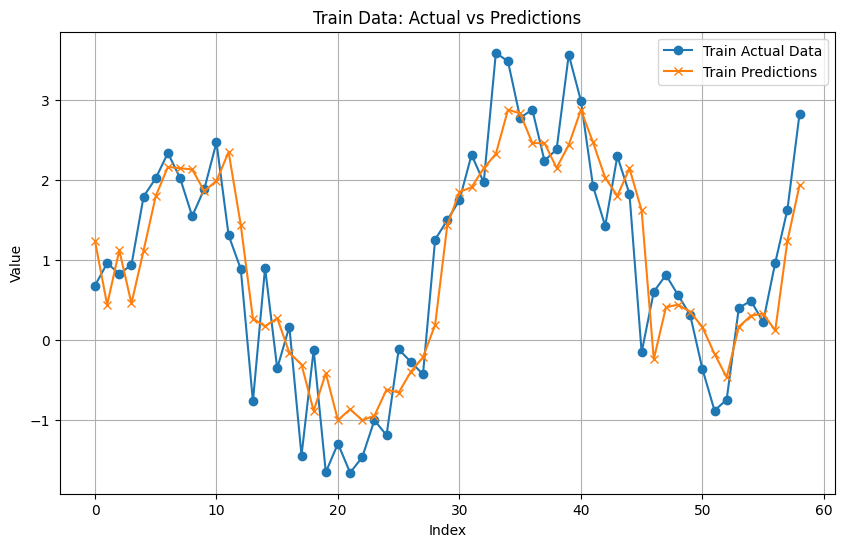

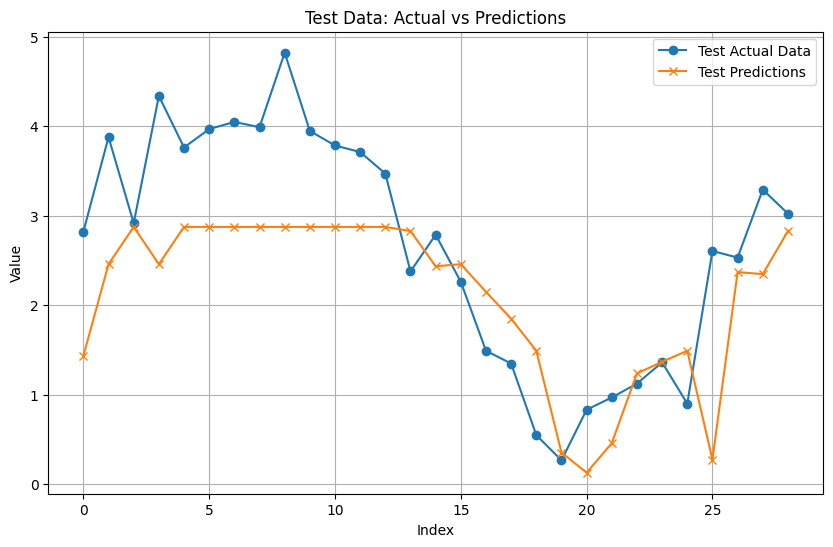

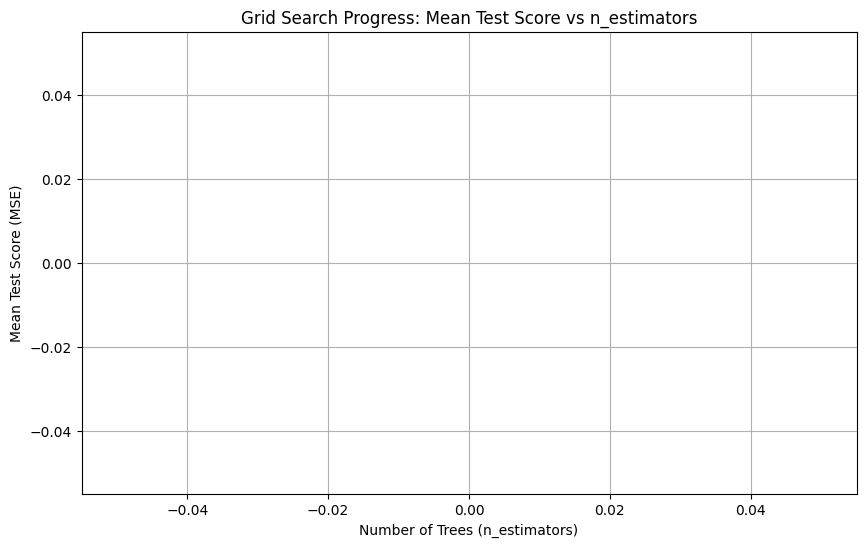

In [2]:
#RandomForestRegressor

# Funktion zur Erstellung von X und y
def create_train_X_y(df):
    train_X = train_df.iloc[:-1].values.reshape(-1, 1)
    train_y = train_df.iloc[1:].values.reshape(-1, 1)
    return train_X, train_y

def create_test_X_y(df):
    test_X = test_df.iloc[:-1].values.reshape(-1, 1)
    test_y = test_df.iloc[1:].values.reshape(-1, 1)
    return test_X, test_y

X_train, y_train = create_train_X_y(train_df)
X_test, y_test = create_test_X_y(test_df)

model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],  # Anzahl der Bäume
    'max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Proben, um einen internen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4],    # Minimale Anzahl von Proben in einem Blattknoten
    'max_features': ['auto', 'sqrt'], # Anzahl der Merkmale, die bei jeder Aufteilung betrachtet werden
    'bootstrap': [True, False]        # Ob Bootstrap-Proben verwendet werden, wenn Bäume gebaut werden
}

# Grid Search mit Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train.ravel())

# Beste Parameter und bestes Ergebnis anzeigen
print("Best Parameter: ", grid_search.best_params_)
print("Best Punktzahl (neg. MSE): ", grid_search.best_score_)

# Beste Modellvorhersagen treffen
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Ergebnisse anzeigen
print("X_train:", X_train.ravel())
print("y_train:", y_train.ravel())
print("Train Predictions:", train_predictions)
print("X_test:", X_test.ravel())
print("y_test:", y_test.ravel())
print("Test Predictions:", test_predictions)

# MSE auf Trainings- und Testdaten
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error best model on traindata:", train_mse)
print("Mean Squared Error best model on testdata:", test_mse)

# Visualisierung der tatsächlichen Daten und Vorhersagen für Trainingsdaten
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_train)), y_train, label='Train Actual Data', marker='o')
plt.plot(range(len(train_predictions)), train_predictions, label='Train Predictions', marker='x')
plt.title('Train Data: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Visualisierung der tatsächlichen Daten und Vorhersagen für Testdaten
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Test Actual Data', marker='o')
plt.plot(range(len(test_predictions)), test_predictions, label='Test Predictions', marker='x')
plt.title('Test Data: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Verbesserung Grid Search visualisieren
results = pd.DataFrame(grid_search.cv_results_)
mean_test_scores = results['mean_test_score'] * -1  # neg_mean_squared_error umkehren

plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_estimators'], mean_test_scores[:len(param_grid['n_estimators'])], marker='o')
plt.title('Grid Search Progress: Mean Test Score vs n_estimators')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Test Score (MSE)')
plt.grid(True)
plt.show()
